## Germany LSTM GDP predictor

In [2]:
# Initial Imports
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import lime
import sklearn

# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [4]:
#df = pd.read_csv(
   # Path("WEOApr2021all.csv"), parse_dates=True
#)

#df = pd.read_csv(
    #Path("GDP.csv"),
    #index_col="DATE",
    #infer_datetime_format=True,
   # parse_dates=True,
#)
#df.tail()
#set date as index 
#create lagged column for next quarters gdp


df = pd.read_csv(
    Path("WEOApr2021all.csv")
)

df = df[(df["Subject Descriptor"]=="Gross domestic product, current prices") & (df["Units"]=="U.S. dollars")]
df.drop(columns=["Subject Descriptor", "Units", "Scale", "Estimates Start After"], inplace=True)
df = df.T
df.columns = df.loc["Country"]
df = df.drop("Country", axis=0)
df.head()

Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
WEO Country Code,512,914,612,614,311,213,911,314,193,122,...,111,298,927,846,299,582,487,474,754,698
ISO,AFG,ALB,DZA,AGO,ATG,ARG,ARM,ABW,AUS,AUT,...,USA,URY,UZB,VUT,VEN,VNM,WBG,YEM,ZMB,ZWE
WEO Subject Code,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,...,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD
Subject Notes,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...
Country/Series-specific Notes,"See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...",...,"See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren..."


In [5]:
Germany_df = df[['Germany']]

Germany_gdp = Germany_df.drop(labels=["WEO Country Code", "ISO", "WEO Subject Code", "Subject Notes", "Country/Series-specific Notes"], axis=0)

Germany_gdp.rename(columns = {'Country':'Year'}, inplace = True)

#df = df.replace(",","", regex=True)
#df = df.astype("float")
#df


Germany_gdp = Germany_gdp.replace(",","", regex=True)
Germany_gdp = Germany_gdp.astype("float")
Germany_gdp

Germany_gdp["lagged GDP"] = Germany_gdp[["Germany"]]
#d['gdp'] = df['gdp'].shift(-5)
Germany_gdp["lagged GDP"] = Germany_gdp['lagged GDP'].shift(10)
Germany_gdp

Country,Germany,lagged GDP
1980,853.705,NaN
1981,718.264,NaN
1982,693.547,NaN
1983,691.912,NaN
1984,651.900,NaN
1985,661.037,NaN
1986,944.124,NaN
1987,1174.860,NaN
1988,1266.620,NaN
1989,1257.390,NaN


In [6]:
def window_data(Germany_gdp, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(Germany_gdp) - window):
        features = Germany_gdp.iloc[i : (i + window), feature_col_number]
        target = Germany_gdp.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [7]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 20

feature_column = 0
target_column = 1
X, y = window_data(Germany_gdp, window_size, feature_column, target_column)
print (f"X sample values:\n{X} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[ 853.705  718.264  693.547  691.912  651.9    661.037  944.124 1174.86
  1266.62  1257.39  1598.64  1875.62  2136.31  2072.46  2209.93  2588.
  2498.11  2214.69  2242.07  2197.13 ]
 [ 718.264  693.547  691.912  651.9    661.037  944.124 1174.86  1266.62
  1257.39  1598.64  1875.62  2136.31  2072.46  2209.93  2588.    2498.11
  2214.69  2242.07  2197.13  1948.84 ]
 [ 693.547  691.912  651.9    661.037  944.124 1174.86  1266.62  1257.39
  1598.64  1875.62  2136.31  2072.46  2209.93  2588.    2498.11  2214.69
  2242.07  2197.13  1948.84  1945.8  ]
 [ 691.912  651.9    661.037  944.124 1174.86  1266.62  1257.39  1598.64
  1875.62  2136.31  2072.46  2209.93  2588.    2498.11  2214.69  2242.07
  2197.13  1948.84  1945.8   2077.02 ]
 [ 651.9    661.037  944.124 1174.86  1266.62  1257.39  1598.64  1875.62
  2136.31  2072.46  2209.93  2588.    2498.11  2214.69  2242.07  2197.13
  1948.84  1945.8   2077.02  2501.01 ]
 [ 661.037  944.124 1174.86  1266.62  1257.39  1598.64  1875

In [8]:
type(X)



#XS = float(X)
#yS = float(y)


numpy.ndarray

In [9]:
# Use 90% of the data for training and the remainder for testing
split = int(0.9 * len(X))
X_train = X[: split]
X_test = X[split - 20:]
y_train = y[: split]
y_test = y[split - 20:]

In [10]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [11]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.0861325 ]
  [0.02392289]
  [0.01346514]
  [0.01293652]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.00350589]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.09432262]
  [0.06271011]
  [0.13077232]
  [0.27057203]
  [0.20823656]
  [0.09562743]
  [0.09951263]
  [0.08007838]]

 [[0.02832485]
  [0.01501291]
  [0.01293652]
  [0.        ]
  [0.00295414]
  [0.09168444]
  [0.08227243]
  [0.03565157]
  [0.        ]
  [0.12961929]
  [0.1208749 ]
  [0.12940809]
  [0.06271011]
  [0.13077232]
  [0.317957  ]
  [0.23269953]
  [0.10137917]
  [0.1053648 ]
  [0.08441796]
  [0.0009686 ]]

 [[0.01777538]
  [0.01442352]
  [0.        ]
  [0.00295414]
  [0.09448067]
  [0.16641378]
  [0.11499086]
  [0.03206543]
  [0.12961929]
  [0.23482647]
  [0.2346408 ]
  [0.09771256]
  [0.13077232]
  [0.317957  ]
  [0.27345193]
  [0.11328887]
  [0.11170221]
  [0.08938244]
  [0.00102109]
  [0.        ]]

 [[0.01707754]
  [0.        ]
  [0.00295414]
  [0.09448067]
  [0.169081

In [12]:
y_train

array([[0.        ],
       [0.1208749 ],
       [0.2346408 ],
       [0.20677647],
       [0.26676878],
       [0.43175966],
       [0.3925314 ],
       [0.26884606],
       [0.28079478],
       [0.26118283],
       [0.15282833],
       [0.15150166],
       [0.20876646],
       [0.39379697],
       [0.52998525],
       [0.54541646],
       [0.60931459],
       [0.79745664],
       [0.93661247],
       [0.7894181 ],
       [0.78718372],
       [0.93827516],
       [0.84258071],
       [0.9318164 ]])

In [14]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [15]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.4

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))


model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer


model.add(Dense(1))

In [16]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error", metrics= ["accuracy"])

In [17]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 5)             140       
_________________________________________________________________
dropout (Dropout)            (None, 20, 5)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 5)             220       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 5)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [18]:
# Train the model
model.fit(X_train, y_train, epochs=200, shuffle=False, batch_size=10, verbose=1)

Epoch 1/200
3/3 [==============================] - 4s 24ms/step - loss: 0.4756 - accuracy: 0.0417
Epoch 2/200
3/3 [==============================] - 0s 18ms/step - loss: 0.3809 - accuracy: 0.0417
Epoch 3/200
3/3 [==============================] - 0s 13ms/step - loss: 0.3707 - accuracy: 0.0417
Epoch 4/200
3/3 [==============================] - 0s 13ms/step - loss: 0.3384 - accuracy: 0.0417
Epoch 5/200
3/3 [==============================] - 0s 15ms/step - loss: 0.3060 - accuracy: 0.0417
Epoch 6/200
3/3 [==============================] - 0s 13ms/step - loss: 0.2728 - accuracy: 0.0417
Epoch 7/200
3/3 [==============================] - 0s 14ms/step - loss: 0.2580 - accuracy: 0.0417
Epoch 8/200
3/3 [==============================] - 0s 14ms/step - loss: 0.2308 - accuracy: 0.0417
Epoch 9/200
3/3 [==============================] - 0s 13ms/step - loss: 0.2165 - accuracy: 0.0417
Epoch 10/200
3/3 [==============================] - 0s 14ms/step - loss: 0.1961 - accuracy: 0.0417
Epoch 11/200
3/3 [=

In [19]:
# Evaluate the model
model.evaluate(X_test, y_test)

1/1 [==============================] - 1s 874ms/step - loss: 0.0167 - accuracy: 0.0435


[0.016742441803216934, 0.043478261679410934]

In [20]:
predicted = model.predict(X_test)
predicted


array([[0.23036614],
       [0.25004846],
       [0.2660693 ],
       [0.28031844],
       [0.29422018],
       [0.3093465 ],
       [0.33031556],
       [0.3570973 ],
       [0.39012447],
       [0.42794946],
       [0.47165424],
       [0.51857305],
       [0.5654249 ],
       [0.6105794 ],
       [0.6515134 ],
       [0.68996185],
       [0.7269716 ],
       [0.7593231 ],
       [0.78773963],
       [0.8146289 ],
       [0.8376039 ],
       [0.8600717 ],
       [0.88582975]], dtype=float32)

In [21]:
X_test

array([[[0.        ],
        [0.0032937 ],
        [0.09448067],
        [0.1690813 ],
        [0.19874877],
        [0.19314307],
        [0.23337764],
        [0.27226669],
        [0.33384611],
        [0.30959354],
        [0.26676878],
        [0.35362972],
        [0.27345193],
        [0.13312902],
        [0.14668502],
        [0.10589048],
        [0.00114617],
        [0.        ],
        [0.04407482],
        [0.17690016]],

       [[0.00389977],
        [0.10534087],
        [0.1690813 ],
        [0.19874877],
        [0.19576456],
        [0.30366499],
        [0.33213908],
        [0.37355272],
        [0.30959354],
        [0.36180969],
        [0.43175966],
        [0.30900778],
        [0.13312902],
        [0.14668502],
        [0.12443496],
        [0.00128081],
        [0.        ],
        [0.04666679],
        [0.18648668],
        [0.27633143]],

       [[0.12472428],
        [0.18851655],
        [0.19874877],
        [0.19576456],
        [0.30609612],
      

In [22]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [23]:
predicted_prices.ravel().shape

(23,)

In [26]:
# Create a DataFrame of Real and Predicted values
GDP = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
GDP

,Real,Predicted
2004,2209.93,2126.514893
2005,2588.00,2171.615967
2006,2498.11,2208.327148
2007,2214.69,2240.978516
2008,2242.07,2272.833740
2009,2197.13,2307.495117
2010,1948.84,2355.544922
2011,1945.80,2416.914062
2012,2077.02,2492.594482
2013,2501.01,2579.269043


<AxesSubplot:>

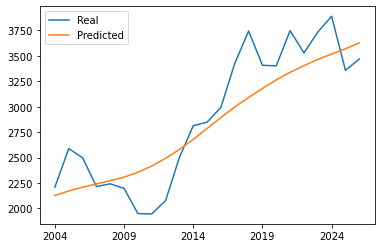

In [27]:
# Plot the real vs predicted prices as a line chart
GDP.plot()

In [29]:
from sklearn.metrics import r2_score

In [31]:
y_true = GDP["Real"]
y_pred = GDP["Predicted"]
r2_score(y_true, y_pred)

0.7899916207074109